In [70]:
from dataset import get_path
from utils import decod, correlate, match_list
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops


In [21]:
path = get_path('LPP_read')
sub = '2'

In [106]:
epo = []
for run in np.arange(1,10):
    bids_path = mne_bids.BIDSPath(
            subject=sub,
            session="01",
            task='listen',
            datatype="meg",
            root=path,
            run=f'0{run}',
        )
    raw = mne_bids.read_raw_bids(bids_path)
    raw.pick_types(meg=True, stim=True)
    raw.load_data()
    raw = raw.filter(0.5, 20)

    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()
    # read events
    meta = pd.read_csv(event_file, sep="\t")
    events = mne.find_events(
        raw, stim_channel="STI101",  shortest_event=1
    )
    word_length_meg = events[:,2] - 2048 # Remove first event: chapter start and remove offset
    word_len_meta = meta.word.apply(len)
    i,j = match_list(word_len_meta,word_length_meg)
    events = events[j]
    # events = events[i]  # events = words_events[i]
    meta = meta.iloc[i].reset_index()

    meta['start'] = events[:,0]/raw.info['sfreq']

    epochs = mne.Epochs(
        raw, events, metadata=meta, tmin=-0.1, tmax=0.6, decim=20, baseline=(-0.1, 0.0)
    )
    epochs.load_data()
    epochs = epochs.pick_types(meg=True, stim=False, misc=False)
    epo.append(epochs)
    
for epoc in epo:
    epoc.info["dev_head_t"] = epo[0].info["dev_head_t"]
    # epo.info['nchan'] = epochs[0].info['nchan']

epochs = mne.concatenate_epochs(epo)


Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 22000 ... 491999 =     22.000 ...   491.999 secs
Ready.
Reading events from /home/is153802/workspace_LPP/data/MEG/LP

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 117 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 469999  =      0.000 ...   469.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.4s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1467 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063]
Adding metadata with 7 columns
1411 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 528999 =     26.000 ...   528.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]
Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 62000 ... 617999 =     62.000 ...   617.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 145 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 555999  =      0.000 ...   555.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.5s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1719 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064 2065 2066]
Adding metadata with 7 columns
1659 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1659 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 18000 ... 505999 =     18.000 ...   505.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 487999  =      0.000 ...   487.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1490 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064 2065 2067]
Adding metadata with 7 columns
1443 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1443 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 10000 ... 469999 =     10.000 ...   469.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 124 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 459999  =      0.000 ...   459.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1373 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2064 2068]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.6s finished


Adding metadata with 7 columns
1335 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1335 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 10000 ... 578999 =     10.000 ...   578.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 568999  =      0.000 ...   568.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1698 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]
Adding metadata with 7 columns
1695 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1695 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-07_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 525999 =     11.000 ...   525.999 secs
Ready.
Reading events from /home/is153802/work

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 140 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 514999  =      0.000 ...   514.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.4s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1553 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063]
Adding metadata with 7 columns
1552 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1552 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-08_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 459999 =      9.000 ...   459.999 secs
Ready.
Reading events from /home/is153802/works

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 112 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 450999  =      0.000 ...   450.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1391 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064 2067 2069]
Adding metadata with 7 columns
1318 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1318 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-09_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 551999 =      9.000 ...   551.999 secs
Ready.
Reading events from /home/is153802/works

/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Omitted 153 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/tmp/ipykernel_797418/310182516.py:11: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Reading 0 ... 542999  =      0.000 ...   542.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.5s finished


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1651 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064 2065]
Adding metadata with 7 columns
1578 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1578 events and 701 original time points (prior to decimation) ...


/tmp/ipykernel_797418/310182516.py:38: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped


/tmp/ipykernel_797418/310182516.py:49: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epo)


Adding metadata with 7 columns
13553 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)


In [108]:
def decod(X, y):
    assert len(X) == len(y)
    # define data
    model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-1, 6, 10)))
    cv = KFold(15, shuffle=True, random_state=0)

    # fit predict
    n, n_chans, n_times = X.shape
    if y.ndim == 1:
        y = np.asarray(y).reshape(y.shape[0],1)
    R = np.zeros((n_times, y.shape[1]))
    
    for t in range(n_times):
        print(".", end="")
        rs = []
        # y_pred = cross_val_predict(model, X[:, :, t], y, cv=cv)
        for train, test in cv.split(X):
            model.fit(X[train,:,t],y[train])
            y_pred = model.predict(X[test,:,t])
            r = correlate(y[test],y_pred)
            rs.append(r)
        R[t] = np.mean(rs)    
        #R[t] = correlate(y, y_pred)
        
    return R



In [111]:
X.shape

(13553, 306, 36)

In [110]:

X = epochs.get_data()
y = epochs.metadata.word.apply(len)


In [112]:
R = decod(X,y)

....................................

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

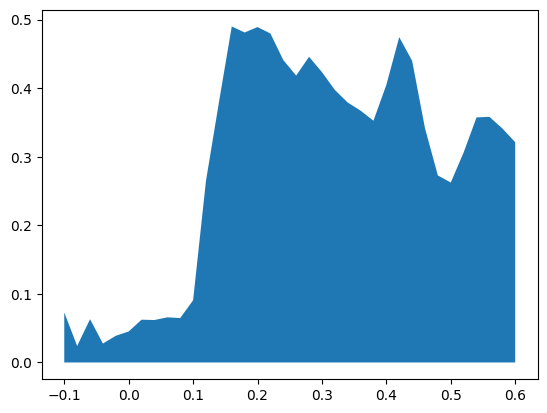

In [116]:
plt.fill_between(epochs.times,np.squeeze(R))

In [32]:
evoked = epochs.average(method='median')

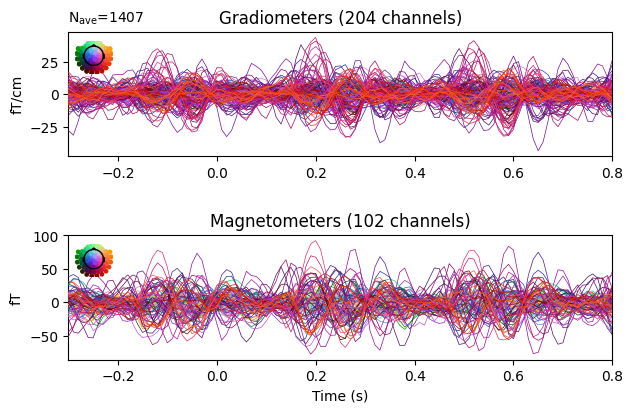

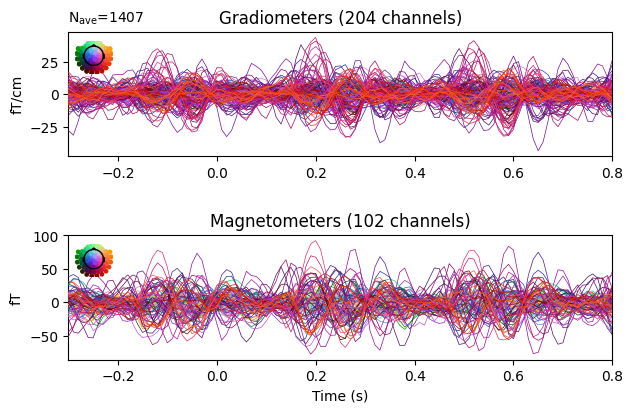

In [33]:
evoked.plot()

In [35]:
epochs.metadata['trigger_value'] = epochs.events[:,2]

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css

Subjects for which the decoding will be tested: 

['1', '2', '3', '4', '5', '6']
Subject 1's decoding started
.Running the script on RAW data:
run 01, subject: 1
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-1/ses-01/meg/sub-1_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : P

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 4 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.rea

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.3s finished


1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Adding metadata with 7 columns
1411 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.Running the script on RAW data:
run 02, subject: 1
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-1/ses-01/meg/sub-1_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 589999 =     26.000 ...   589.999 s

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.4s finished


1607 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Adding metadata with 8 columns
2973 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)


/tmp/ipykernel_1886153/816539245.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


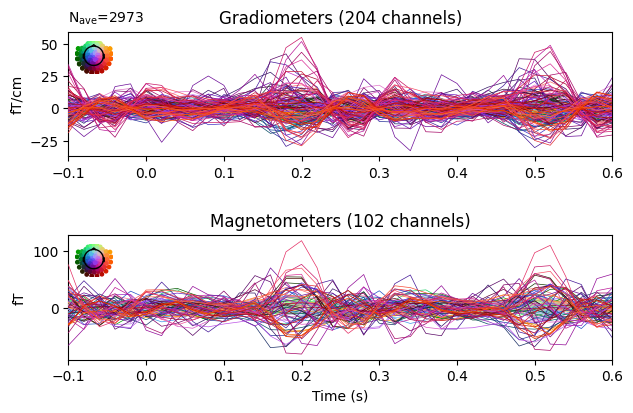

....................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    7.8s finished


combining channels using "gfp"
combining channels using "gfp"
Overwriting existing file.
Saving report to : /media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/figures/reading_decoding_embeddings.html
Finished!
Subject 2's decoding started
.Running the script on RAW data:
run 01, subject: 2
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 3

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 117 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1467 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.9s finished


Adding metadata with 7 columns
1411 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.Running the script on RAW data:
run 02, subject: 2
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-2/ses-01/meg/sub-2_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 26000 ... 528999 =     26.000 ...   528.999 s

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Using 4 HPI coils: 293 307 314 321 Hz
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 502999  =      0.000 ...   502.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Trigger channel has a non-zero initial value of 2048 (consider using initial_event=True to detect this event)
1607 events found
Event IDs: [2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062
 2063 2064]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    8.4s finished


Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped


/tmp/ipykernel_1886153/816539245.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


Adding metadata with 8 columns
2973 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)


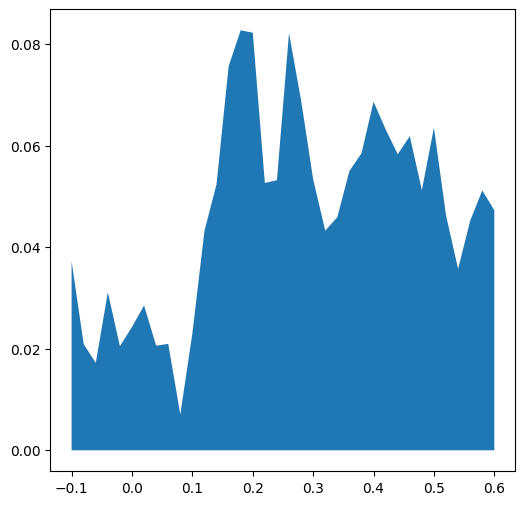

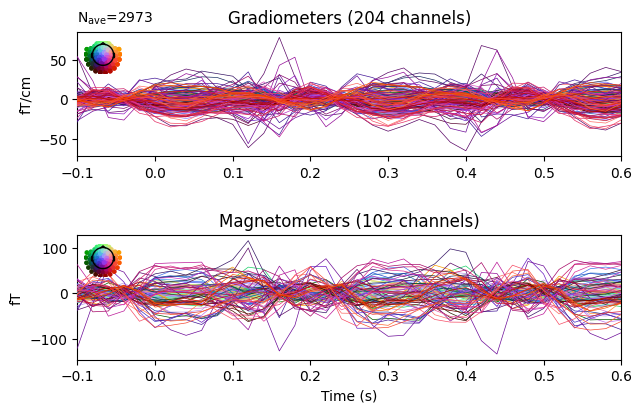

....................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    9.8s finished


combining channels using "gfp"
combining channels using "gfp"
Overwriting existing file.
Saving report to : /media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/figures/reading_decoding_embeddings.html
Finished!
Subject 3's decoding started
.Running the script on RAW data:
run 01, subject: 3
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 3

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.re

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.5s finished


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Adding metadata with 7 columns
1411 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.Running the script on RAW data:
run 02, subject: 3
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 14000 ... 532999 =     14.000 ...   532.999 s

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 99 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.9s finished


1607 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Adding metadata with 8 columns
2973 matching events found
Applying baseline correction (mode: mean)


/tmp/ipykernel_1886153/816539245.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


Created an SSP operator (subspace dimension = 13)


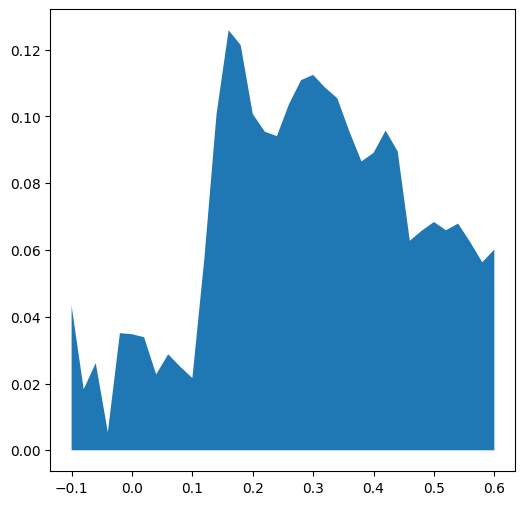

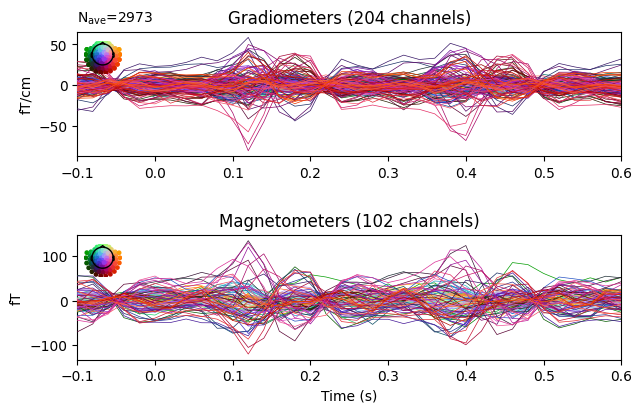

....................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   12.8s finished


combining channels using "gfp"
combining channels using "gfp"
Overwriting existing file.
Saving report to : /media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/figures/reading_decoding_embeddings.html
Finished!
Subject 4's decoding started
.Running the script on RAW data:
run 01, subject: 4
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-4/ses-01/meg/sub-4_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 3

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 133 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Adding metadata with 7 columns
1411 matching events found


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.Running the script on RAW data:
run 02, subject: 4
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-4/ses-01/meg/sub-4_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 15000 ... 520999 =     15.000 ...   520.999 s

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 137 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


1606 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped


/tmp/ipykernel_1886153/816539245.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


Adding metadata with 8 columns
2973 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)


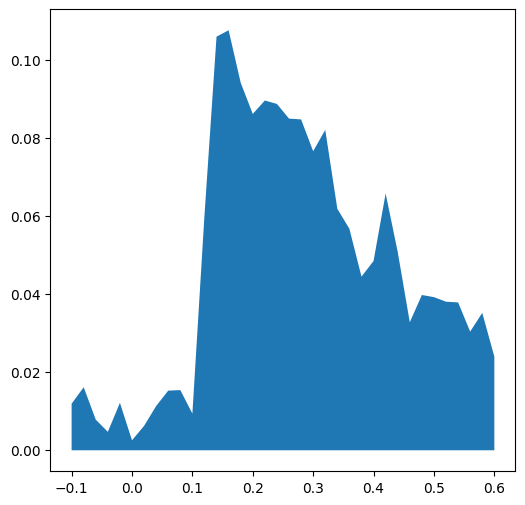

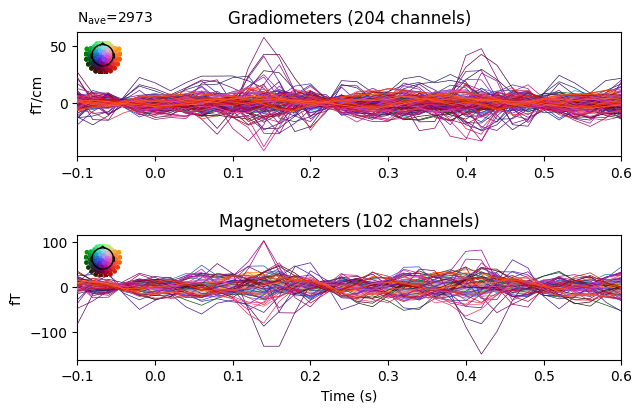

....................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    9.4s finished


combining channels using "gfp"
combining channels using "gfp"
Overwriting existing file.
Saving report to : /media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/figures/reading_decoding_embeddings.html
Finished!
Subject 5's decoding started
.Running the script on RAW data:
run 01, subject: 5
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-5/ses-01/meg/sub-5_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 3

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


1468 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


Adding metadata with 7 columns
1411 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1411 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
.Running the script on RAW data:
run 02, subject: 5
Opening raw data file /home/is153802/workspace_LPP/data/MEG/LPP/BIDS_lecture/sub-5/ses-01/meg/sub-5_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 8000 ... 514999 =      8.000 ...   514.999 se

/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/readi

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


1605 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.2s finished


Adding metadata with 7 columns
1562 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated
Using data from preloaded Raw for 1562 events and 701 original time points (prior to decimation) ...


/media/cb271805/272a9f9d-f140-48d6-b390-094ccc29aae0/workspace-LPP/code/neurospin-petit-prince/decoding/reading/dataset.py:84: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=20 parameter will result in a sampling frequency of 50.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(


0 bad epochs dropped
Adding metadata with 8 columns
2973 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)


/tmp/ipykernel_1886153/816539245.py:46: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(epochs)


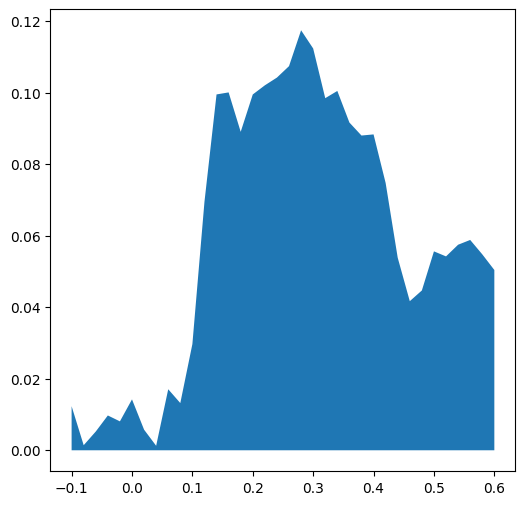

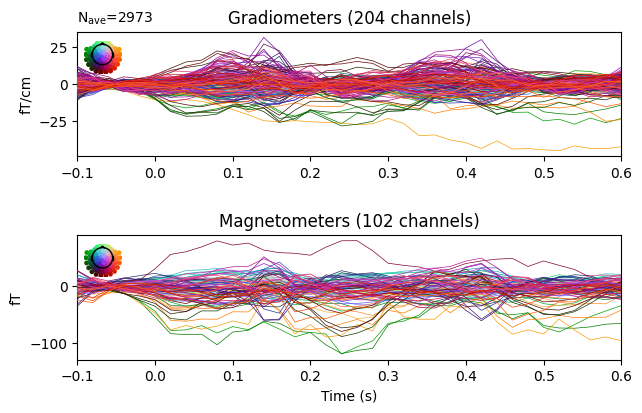

...

LinAlgError: SVD did not converge

In [1]:
from dataset import get_path, get_subjects, epoch_data
from utils import decod, correlate, match_list
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne
import spacy

nlp = spacy.load('fr_core_news_sm')

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops
import matplotlib.pyplot as plt
import matplotlib


report = mne.Report()
path = get_path('LPP_read')
subjects = get_subjects(path)
RUN = 2

print("\nSubjects for which the decoding will be tested: \n")
print(subjects)

for subject in subjects:  # Ignore the first one

    print(f"Subject {subject}'s decoding started")
    epochs = []
    for run_id in range(1, RUN + 1):
        print(".", end="")
        epo = epoch_data(subject, "%.2i" % run_id, task='listen', path=path)
        epo.metadata["label"] = f"run_{run_id}"
        epochs.append(epo)

    # Quick fix for the dev_head: has to be
    # fixed before doing source reconstruction
    for epo in epochs:
        epo.info["dev_head_t"] = epochs[0].info["dev_head_t"]
        # epo.info['nchan'] = epochs[0].info['nchan']

    epochs = mne.concatenate_epochs(epochs)

    # Get the evoked potential averaged on all epochs for each channel
    evo = epochs.average(method="median")
    evo.plot(spatial_colors=True)

    # Handling the data structure
    epochs.metadata["kind"] = epochs.metadata.trial_type.apply(
        lambda s: eval(s)["kind"]
    )
    epochs.metadata["word"] = epochs.metadata.trial_type.apply(
        lambda s: eval(s)["word"]
    )

    # Run a linear regression between MEG signals
    # and word frequency classification
    X = epochs.get_data()

    embeddings = epochs.metadata.word.apply(lambda word: nlp(word).vector).values
    embeddings = np.array([emb for emb in embeddings])

    y = embeddings

    R_vec = decod(X, y)
    R_vec_avg = np.mean(R_vec,axis = 1)

    fig, ax = plt.subplots(1, figsize=[6, 6])
    dec = plt.fill_between(epochs.times, R_vec_avg)
    # plt.show()
    report.add_evokeds(evo, titles=f"Evoked for sub {subject} ")
    report.add_figure(fig, title=f"decoding for subject {subject}")
    # report.add_figure(dec, subject, tags="word")
    report.save("./figures/reading_decoding_embeddings.html", open_browser=False, overwrite=True)

    print("Finished!")


In [12]:

from dataset import get_path, get_subjects, epoch_data
from utils import decod, correlate, match_list
import mne_bids
from pathlib import Path
import pandas as pd
import numpy as np
import mne
import spacy

nlp = spacy.load('fr_core_news_sm')

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import RidgeCV
from wordfreq import zipf_frequency
from Levenshtein import editops
import matplotlib.pyplot as plt
import matplotlib
R_vec = decod(X, y)

.

AttributeError: 'bool' object has no attribute 'any'

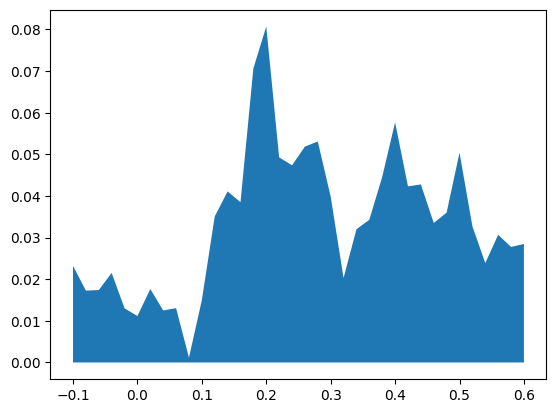

In [20]:
dec = plt.fill_between(epochs.times, np.mean(R_vec,axis = 1))